This post describes the use of bayesian polynomial regression to estimate chlorophyll from remote sensing reflectance; the output is contrasted to that obtained via the frequentist ordinary least squares regression.

Chlorophyll is estimated from ocean color remote sensing data  using one of two main types of algorithms; semi-analytical or empirical. The latter is a polynomial model, where the input is a ratio of bands and the coefficients are obtained via ordinary least squares fitting. These models are usually more successful than their semi-analytical counterparts and as a result are at the forefront of the operational algorithmic arsenal used by the Ocean Biology Processing Group at NASA Goddard. <!--TEASER_END-->Like all models these suffer from a number of shortcomings. One of these is the lack of algorithm uncertainty, which makes it difficult to formulate some kind of confidence around the final product, chlorophyll. Moreover, data preparation, model training and model testing are also poorly documented. This lack of standardized algorithm development makes verification of previous results and duplication of procedure for algorithm development challenging. In this post, I demonstrate bayesian regression by focusing on the OC4 algorithm. The OC4 algorithm is part of the OCx family of empirical algorithms, which are  generally expressed as follows:
$$ log_{10}\left(chlor_a\right) = a_0 + \sum_{i=1}^{4}a_ilog_{10}\left(\frac{max\left(Rrs\left(\lambda_{blue}\right)\right)}{Rrs\left(\lambda_{green}\right)}\right)^i$$

The dataset used here is as close as possible to the dataset used for the calculation of the coefficients of the OC4 polynomial, the latest of which is  [OC4v6](https://oceancolor.gsfc.nasa.gov/atbd/chlor_a/)), obtained a few years ago using a frequentist least squares regression. I'll redo a least squares fit using the present dataset. I will then repeat the exercise using a bayesian regression approach, and explore the much richer information content of the inference results.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import os
import pathlib
from scipy.stats import norm
import matplotlib.pyplot as pl
import pymc3 as pm
import pandas as pd
import seaborn as sb
from matplotlib import rcParams
import pickle
from sklearn.metrics import mean_squared_error
from theano import shared

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:90% !important;}</style>"))

rcParams['axes.formatter.limits'] = (-2, 3)
rcParams['xtick.labelsize'] = 14
rcParams['ytick.labelsize'] = 14
rcParams['axes.labelsize'] = 14
rcParams['axes.labelweight'] = 'normal'
rcParams['axes.labelpad'] = 12
rcParams['font.size'] = 14
rcParams['axes.titlesize'] = 18
rcParams['figure.titlesize'] = 20
sb.set_style(style=None, rc=rcParams)

%matplotlib inline

Some helper functions:

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def FitPoly(X,y, order=4, lin=False):
    """
    Numpy regression. Returns coeffs.
    kwargs:
        lin: specifies whether data is log transformed. Data is log transformed if not."""
    if lin:
        X = np.log10(X)
        y = np.log10(y)
    coeffs = np.polyfit(X,y,deg=order)
    return coeffs


def GetPPC(data, mcChain, pmModel):
    """
    Runs post predictive checks (PPC).
    Returns 50% and 95% Highest Probability Density (HPD) intervals of predicted chlorophyll.
    Inputs:
        data: log of band ratio, pandas Series object
        mcChain: pymc3 trace object, result of mcmc sampling
        pmModel: pymc3 model object.
    Outputs:
        sig0: 50% HPD interval of predicted log chlorophyll
        sig1: 95% HPD interval of predicted log chlorophyll
    """
    
    ppcTrain = pm.sample_ppc(mcChain, samples=1000, model=pmModel)
    # sample posterior predictive check for 50% and 95% density interval
    idx = np.argsort(data.values)
    sig0 = pm.hpd(ppcTrain['chlPred'], alpha=0.5)[idx] 
    sig1 = pm.hpd(ppcTrain['chlPred'], alpha=0.05)[idx]
    return sig0, sig1

def PlotPPC(data, chlObs, sig0, sig1, bayesCoeffs, oc4V6Coeffs=[], myOLSCoeffs=[],
           titleTail='on Training Set'):
    """
    Plots Posterior predictive checks, overlaid with 50% and 95% HPDs of predicted log chlorophyll
    Optionally adds result of OC4V6 estimation, and estimation from OLS computed in this notebook.
    Inputs:
        data: log of band ratio, pandas Series object
        chlObs: log of in situ observed chl, pandas Series object
        sig0: 50% HPD interval of predicted log chlorophyll
        sig1: 95% HPD interval of predicted log chlorophyll
        bayesCoeffs: point estimate of bayesian regression coefficients
        oc4v6Coeffs: historical OC4V6 coefficients
        myOLSCoeffs: frequentist OLS coefficients
    Outputs:
        axis handle to resulting plot.
    """
    chlBayes=0
    idx = np.argsort(data.values)
    ocxRatio_ord = data.values[idx]
    ocxRatioMock = np.linspace(data.min(),data.max(),100)
    for i,coeff in enumerate(bayesCoeffs):
        chlBayes += coeff*ocxRatioMock**i
    pl.figure(figsize=(16,10))
    pl.fill_between(ocxRatio_ord, sig0[:,0], sig0[:,1], color='k', alpha=1, label='50% HPD.')
    pl.fill_between(ocxRatio_ord, sig1[:,0], sig1[:,1], color='darkgray', alpha=0.5, label='95% HDP')
    pl.plot(data,chlObs, 'ko', alpha=0.5, markeredgecolor='k',  label='Observation')
    if len(oc4V6Coeffs)>0:
        oc4V6Modl=0
        for i, coef in enumerate(oc4V6Coeffs):
            oc4V6Modl += coef * ocxRatioMock**i
        pl.plot(ocxRatioMock,oc4V6Modl,'r', linewidth=3, linestyle='--', label='OC4v6')
    if len(myOLSCoeffs)>0:
        myChlModl=0
        for i,coeff in enumerate(myOLSCoeffs[::-1]):
            myChlModl+= coeff * ocxRatioMock**i
        pl.plot(ocxRatioMock,myChlModl,'m', linewidth=5, label='OLS')
    pl.plot(ocxRatioMock,chlBayes,'b', linewidth=2, label='Bayesian OC4')
    pl.xlabel(r'$log_{10}\frac{max(Rrs\left(\lambda_{blue}\right))}{Rrs\left(\lambda_{green}\right)}$', fontsize=20)
    pl.ylabel(r'$log_{10}\left(chlor_a\right)$', fontsize=20);
    pl.legend(fontsize=14);
    pl.title('Posterior Predictive Check %s' % titleTail);
    return pl.gca()

In [4]:
home = pathlib.Path.home()
root = home / 'DEV-ALL/Bayesian_Chl_Algorithms/pickleJar/'

In [5]:
dfNomadV2 = pd.read_pickle(os.path.join(root, 'NOMADV2SWFClean.pkl'))

Next is to inspect the data, which again, in contrast to the description found [here](https://madhatter106.github.io/DataScienceCorner/posts/getting-nomadata-into-a-pandas-dataframe/), chlorophyll from fluorescence is included when hplc chlorophyll is not available.

In [6]:
dfNomadV2.describe()

,id,depth,rrs411,rrs443,rrs489,rrs510,rrs555,rrs670,hplc_chl,fluo_chl,chl_all
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000,417.000000,794.000000,1016.000000
mean,4598.373031,661.871063,0.004701,0.004743,0.005511,0.005304,0.005418,0.001571,5.348145,3.361652,4.042444
std,2318.827769,1462.690737,0.003984,0.003586,0.004028,0.004294,0.005260,0.002387,9.345286,6.713694,7.736291
min,1441.000000,0.000000,0.000051,0.000190,0.000367,0.000497,0.000417,0.000036,0.017000,0.031000,0.017000
25%,2118.750000,8.000000,0.002000,0.002338,0.003063,0.002900,0.001886,0.000200,0.642000,0.303723,0.349475
50%,3702.500000,25.000000,0.003400,0.003800,0.004695,0.003800,0.003262,0.000614,1.684000,1.041000,1.169500
75%,7036.250000,171.500000,0.006500,0.006200,0.006400,0.006100,0.007201,0.002000,5.389000,3.282500,3.752000
max,7831.000000,5707.000000,0.030600,0.027601,0.030200,0.032900,0.046600,0.027700,70.213300,77.864800,77.864800


In [7]:
dfNomadV2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 11 columns):
id          1016 non-null int32
depth       1016 non-null float64
rrs411      1016 non-null float64
rrs443      1016 non-null float64
rrs489      1016 non-null float64
rrs510      1016 non-null float64
rrs555      1016 non-null float64
rrs670      1016 non-null float64
hplc_chl    417 non-null float64
fluo_chl    794 non-null float64
chl_all     1016 non-null float64
dtypes: float64(10), int32(1)
memory usage: 91.3 KB


Looking at the immediately relevant data graphically:

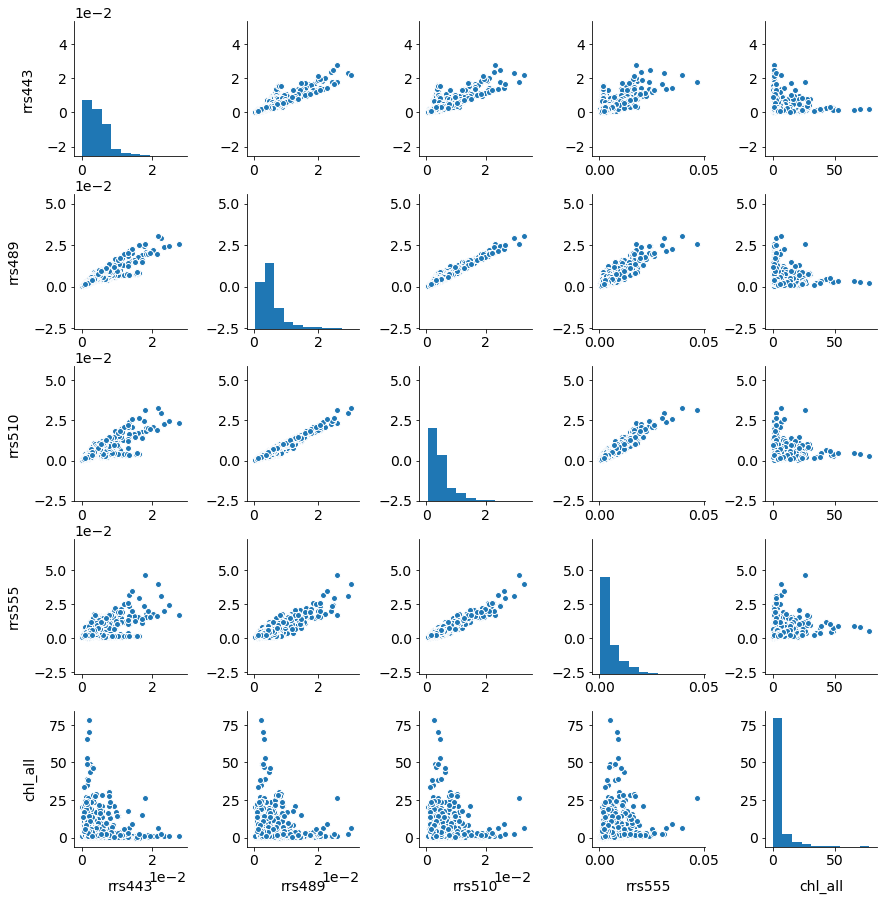

In [8]:
#pl.figure(figsize=(20,20))
sb.pairplot(dfNomadV2, vars=['rrs443', 'rrs489', 'rrs510', 'rrs555','chl_all']);

There's a strong collinearity particulary among neighboring bands. In a multivariate regression that might be a problem. Here though we use a ratio of the max of three adjacent bands (blue to blue-green) to the next band (green), so this is not necessarily a problem. The data appears mostly lognormally distributed (*cf. also Campbell et al, 1995*). Next is to create a maxBlue column and a Blue2GreenRatio column, followed by a log tranforming the blue2green ratio and the chlorophyll data. These will go in a new DataFrame. I'll keep the *id* column as well in case I need to refer back to the original dataset.

In [9]:
dfNomadV2['maxBlue'] = dfNomadV2.loc[:, ['rrs443','rrs489','rrs510']].max(axis=1)
dfNomadV2['blue2green'] = dfNomadV2.maxBlue / dfNomadV2.rrs555
dfLogOCx = pd.DataFrame(columns=['id','mxBl2Gr', 'chl',])
dfLogOCx['id'] = dfNomadV2.id
dfLogOCx['mxBl2Gr'] = np.log10(dfNomadV2.blue2green.values)
dfLogOCx['chl'] = np.log10(dfNomadV2.chl_all.values)

And let's inspect the data again

In [10]:
dfLogOCx.head()

,id,mxBl2Gr,chl
0,1565,-0.267867,1.581950
1,1566,-0.220457,1.544192
2,1567,-0.268537,1.429914
3,1568,-0.279976,1.680879
4,1559,-0.167733,1.371991


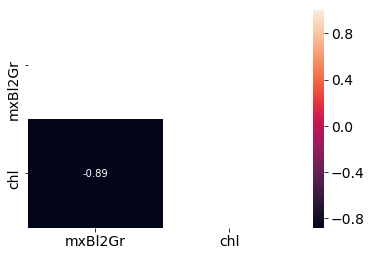

In [11]:
sb.heatmap(dfLogOCx[['mxBl2Gr', 'chl']].corr(), annot=True, mask=np.triu(np.ones((2,2))))

In [11]:
dfLogOCx.describe()

,id,mxBl2Gr,chl
count,1016.000000,1016.000000,1016.000000
mean,4598.373031,0.117382,0.089204
std,2318.827769,0.287944,0.702093
min,1441.000000,-0.353183,-1.769551
25%,2118.750000,-0.087723,-0.456596
50%,3702.500000,0.021409,0.068000
75%,7036.250000,0.255020,0.574263
max,7831.000000,0.982648,1.891341


In [12]:
dfLogOCx.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1016 entries, 0 to 4458
Data columns (total 3 columns):
id         1016 non-null int32
mxBl2Gr    1016 non-null float64
chl        1016 non-null float64
dtypes: float64(2), int32(1)
memory usage: 27.8 KB


Pair plotting just the data relevant to the upcoming regression exercise...

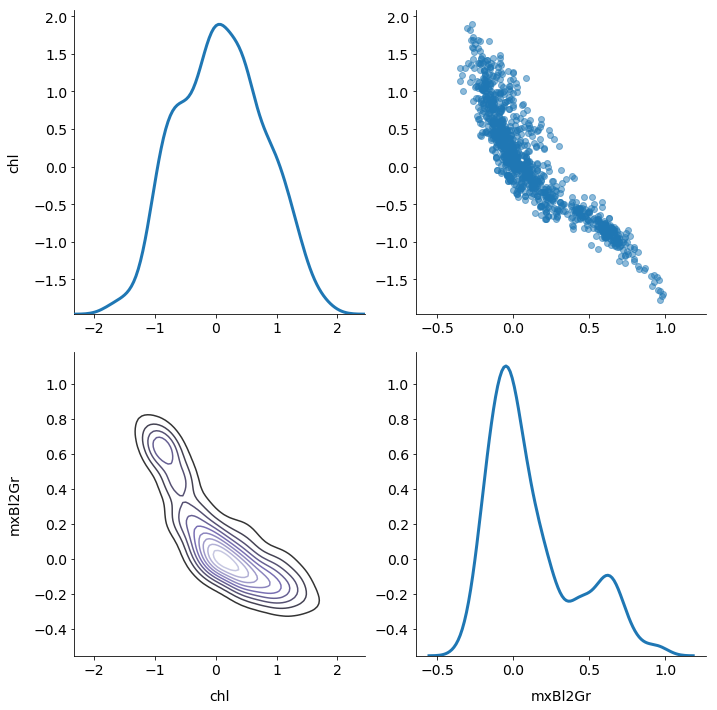

In [13]:
g = sb.PairGrid(dfLogOCx, vars=['chl', 'mxBl2Gr'],size=5, diag_sharey=False);
g = g.map_upper(pl.scatter,alpha=0.5)
g = g.map_diag(sb.kdeplot, lw=3)
g = g.map_lower(sb.kdeplot, cmap="Purples_d");

Now fitting the data to a 4th order polynomial regression and printing the coefficents:

In [14]:
genericOC4_Coefs = FitPoly(dfLogOCx.mxBl2Gr.values,dfLogOCx.chl,lin=False)
print(genericOC4_Coefs[::-1])

[ 0.24120683 -3.10789592  3.1769156  -0.76503841 -1.38077655]


Let's first confirm the numbers make sense by plotting modeled chl to field data:    

In [15]:
mdlFreq= np.poly1d(genericOC4_Coefs) # encapsulate the fit results into a polynomial object
chlMdlFreq = mdlFreq(dfLogOCx.mxBl2Gr) # evaluate polynomial with input data

Out of curiosity I'm also going to evaluate the use of OC4v6 coefficients:

$a_i$ = [0.3272, -2.9940, 2.7218, -1.2259, -0.5683]

In [16]:
OC4v6_coeffs = [0.3272, -2.9940, 2.7218, -1.2259, -0.5683]
mdlOC4v6 = np.poly1d(OC4v6_coeffs[::-1])
chlMdlOc4v6 = mdlOC4v6(dfLogOCx.mxBl2Gr)

In [17]:
np.exp(1.2)

3.3201169227365472

Plotting both OLS yields...

In [18]:
dfLogOCx.chl.shape, chlMdlFreq.shape, chlMdlOc4v6.shape

((1016,), (1016,), (1016,))

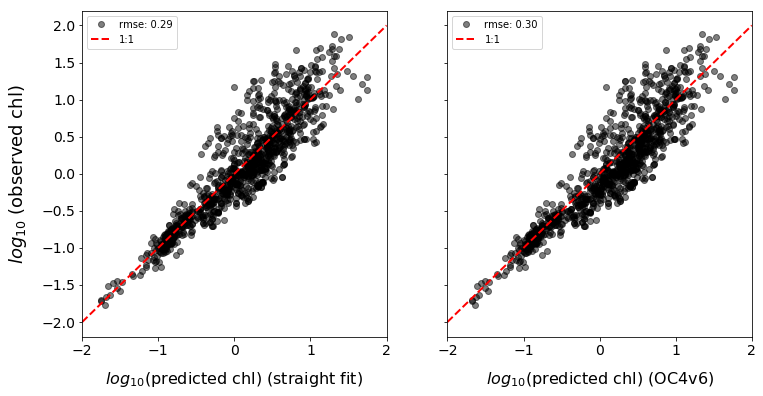

In [19]:
f, axs = pl.subplots(ncols=2,figsize=(12, 6), sharey=True)
lbls = [rmse(dfLogOCx.chl.values, chlMdlFreq), rmse(dfLogOCx.chl.values, chlMdlOc4v6)]
for i, (ax, res, name) in enumerate(zip(axs, [chlMdlFreq, chlMdlOc4v6],
                                       [r'$log_{10}$(predicted chl) (straight fit)',
                                        r'$log_{10}$(predicted chl) (OC4v6)'])):
    ax.plot(res, dfLogOCx.chl, 'ko', alpha=0.5, label='rmse: %.2f' %lbls[i]);
    ax.plot([-2,2],[-2,2], 'r--',linewidth=2 ,label='1:1')
    ax.set_xlabel(name, fontsize=16)
    ax.set_xlim((-2,2))
    if i == 0:
        ax.set_ylabel(r'$ log_{10}$ (observed chl)', fontsize=18)

    ax.legend(loc='best')

Metrics for my freq. model

**Bayesian linear regression**

For now, I am simply going to assume I'm still looking for a $4^{th}$ order polynomial. Model comparison will be the subject of a subsequent post.
First I have to specify some priors around the coefficients. I'll assume weakly informative gaussian priors. Note that using gaussian priors on the coefficients is the bayesian version of ridge regression, and is therefore inherently more robust.

Before deciding an appropriate distribution for the likelihood, I will check the normality of the  data by way of a normality plot, as well as a comparison between the cummulative distribution function (CDF) of the data and a normal standard distribution.

The above suggests that a normal distribution might be a good candidate to apply to the likelihood.
Next is to setup the bayesian model. Note the input data is cast as a [theano shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables).  This is not necessary to run the model below, but makes it easy to run out-of-sample tests during validation (see further below).

In [20]:
ocxRatio = dfLogOCx.mxBl2Gr
chlObs = dfLogOCx.chl
ocxRatioShrd = shared(ocxRatio.values)

In [21]:
with pm.Model() as model_OCx_norm:
    a0 = pm.Normal('a0', mu=0, sd=10)
    a1 = pm.Normal('a1', mu=0, sd=10)
    a2 = pm.Normal('a2', mu=0, sd=10)
    a3 = pm.Normal('a3', mu=0, sd=10)
    a4 = pm.Normal('a4', mu=0, sd=10)
    epsilon = pm.Uniform('epsilon', lower=0, upper=10)
    mu = a0 + a1 * ocxRatioShrd + a2 * ocxRatioShrd**2 + a3 * ocxRatioShrd**3 + a4 * ocxRatioShrd**4
    chlPred = pm.Normal('chlPred', mu=mu, sd=epsilon, observed=chlObs)
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    traceOCx_norm = pm.sample(10000, step=step, start=start)

logp = -202.47, ||grad|| = 1.2693: 100%|██████████| 51/51 [00:00<00:00, 2197.82it/s]   
100%|██████████| 10500/10500 [01:02<00:00, 169.01it/s]


Posteriors marginals are plotted below alongside the trace for each coefficient; the latter, to verify the health of the MCMC chains. The OC4v6 coefficients (**red line**) are plotted for reference.

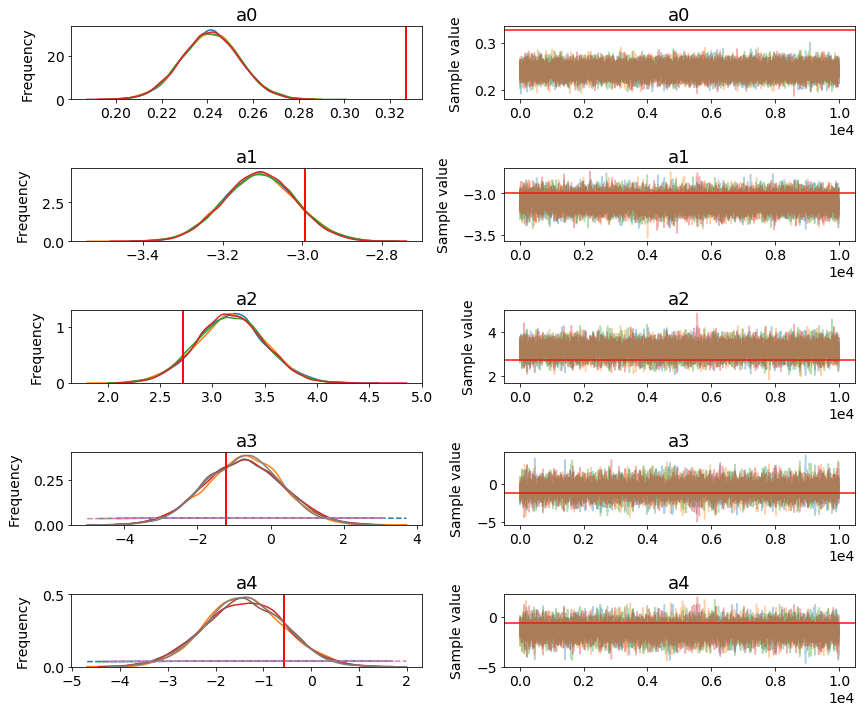

In [22]:
varnames=['a%d' %d for d in range(5)]
refvals = {'a%d' %d: rv for d,rv in zip(range(5), OC4v6_coeffs) }
ax = pm.traceplot(traceOCx_norm, varnames=varnames, lines=refvals,
                  priors=[None] * 3 + [pm.Normal.dist(mu=0, sd=10)] * 2);

### Marginals of the Posterior Distributions
Next is to examine posteriors. This can be done in a number of ways for better insight into the regression. Below is a tabulated summary followed by visualizations of the marginals, including 95% Highest Probability Density (HPD - sometime referred to as *credibility interval*). On the posterior distribution plots, the **<u>green</u>** reference line indicates 0. A parameter with a distribution that overlaps the zero-line may not be a significant contributor. A potential cause are a problematic model formulation (e.g. too many parameters).

In [25]:
pm.df_summary(traceOCx_norm, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0,0.241251,0.012772,0.000075,0.215990,0.266179,19983.0,0.999965
a1,-3.107758,0.090213,0.000881,-3.284462,-2.931718,10313.0,0.999989
a2,3.171730,0.327209,0.003041,2.516193,3.802312,8052.0,0.999959
a3,-0.752119,1.068244,0.012776,-2.788535,1.408678,5697.0,0.999958
a4,-1.388693,0.837966,0.010040,-3.038117,0.261664,5973.0,0.999962


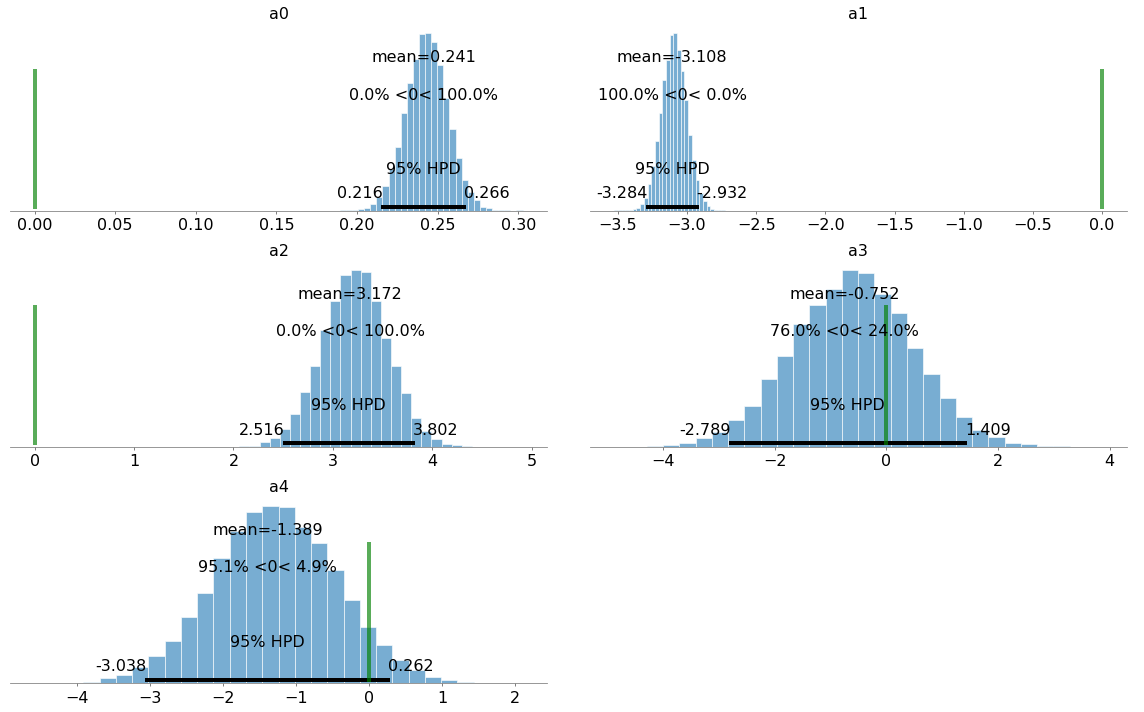

In [26]:
pm.plot_posterior(traceOCx_norm, varnames=varnames, alpha=0.6, ref_val=0, figsize=(16, 10));

The main takeaway from the above is the comparatively wide distributions of a3 and a4, implying larger uncertainty, but more importantly that both distributions's 95% Highest probability densities straddle the zero line. I'll explore some more before concluding. 

### Covariation among model parameters
To get a sense of how much more information each regression coefficient contributes to the larger picture, we can pairwise plot coefficient relationship.

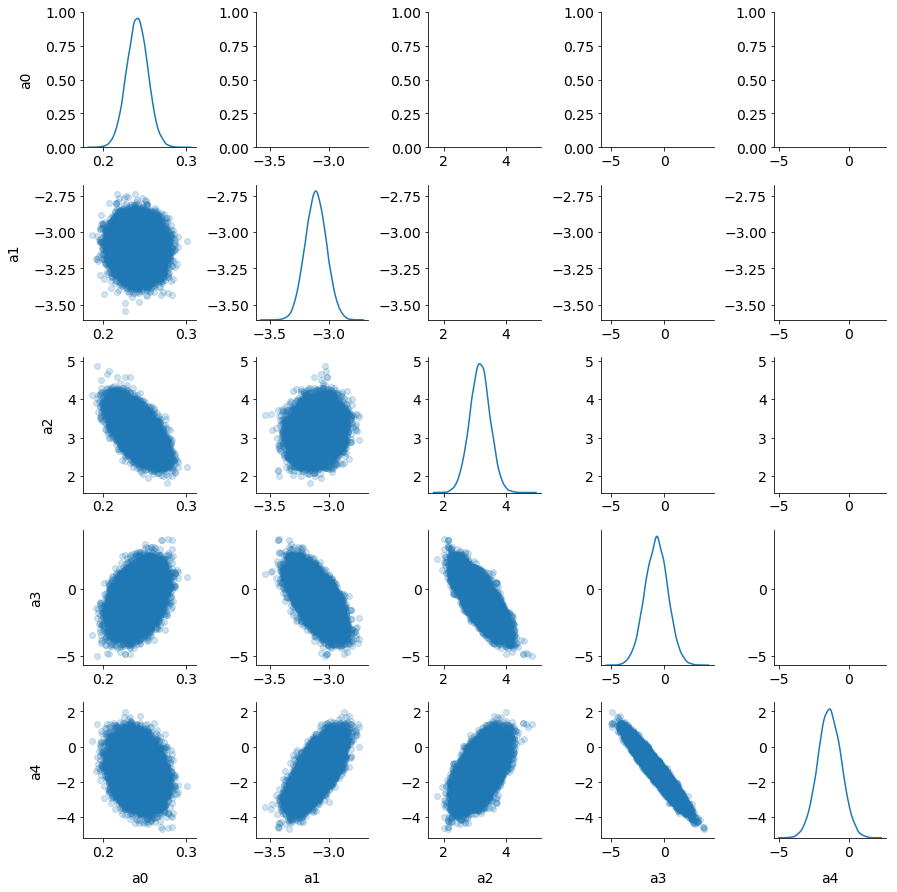

In [28]:
df_trace = pm.trace_to_dataframe(traceOCx_norm, 
                                 varnames=['a%d' %d for d in range(5)])
g = sb.PairGrid(df_trace, diag_sharey=False)
g = g.map_diag(sb.kdeplot)
g = g.map_lower(pl.scatter, alpha=0.2)

There is often a weak correlation among most parameters, which is not all that unusual. However, a relatively strong correlation can be seen between *a3*, and *a4*. This, in addition to the previous observations about *a3* and *a4* indicate that the use of a fourth order polynomial adds little information to the prediction effort; A third order may ultimately generalize better. That will be the subject of a subsequent post on model comparison.

### Posterior Predictive Checks
One concern with any model is to validate it. Posterior predictive checks allow to do just that by sampling from the posterior and see how well it compares with the data at hand. Like so...

In [29]:
sig0, sig1 = GetPPC(data=ocxRatio, mcChain=traceOCx_norm, pmModel=model_OCx_norm)

  0%|          | 0/1000 [00:00<?, ?it/s]


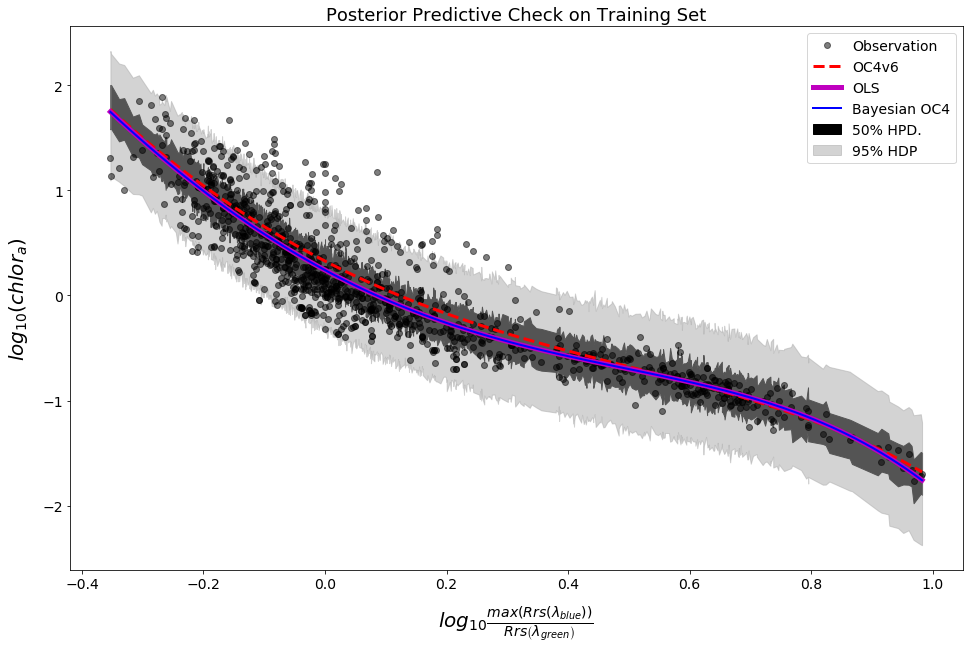

In [31]:
bayesCoeffs = [traceOCx_norm['a%d' %i].mean() for i in range(5)]
ax = PlotPPC(ocxRatio, chlObs, sig0, sig1, bayesCoeffs, oc4V6Coeffs=OC4v6_coeffs, myOLSCoeffs=genericOC4_Coefs)

['a0', 'a1', 'a2', 'a3', 'a4', 'epsilon_interval__', 'epsilon']

The 50 and 95% highest probability density intervals (HPD) show where we expect to see 50 and 95% of future data. There are quite a few data points outside of the 95% HPD of the predicted data. This may suggest that the model has trouble coping with the higher-than-expected variance inherent in the data; i.e. there is a overdispersion problem.
Let's calculate metrics for this model. The majority of the training data falls inside that interval. But there are some outliers (to this model), particularly when chlorophyll concentration is above $ 1 \ mg m^{-3}$. I'll investigate this point in another post.

In [106]:
chlBayesReal=0
for i in range(5):
    chlBayesReal += chainOCx_norm['a%d' %i].mean()*ocxRatio**i
print("rmse, this fit: %.2f " % rmse(dfLogOCx.chl.values, chlMdlFreq))
print("rmse, OC4v6: %.2f " % rmse(dfLogOCx.chl.values, chlMdlOc4v6))
print("rmse, Bayes chl: %.2f" % rmse(dfLogOCx.chl.values, chlBayesReal))

rmse, this fit: 0.29 
rmse, OC4v6: 0.30 
rmse, Bayes chl: 0.29


So frequentist diagnostiscs show the Bayesian model fit matches the least squares fit on training data, as it should since I used uninformative priors. This is not sufficient to validate a model however, as the model has not yet been tested on new data.

### Predicting Outcome from New Data
A machine learning practitioner who what (s)he's doing will want to apply the model to data that has not been used in the fitting process to assess the model's skill in real world predictions. The advantage in this particular case however is that in addition to prediction, we'll get uncertainties, not really available off the shelf with scikit-learn or other machine learning libraries. Even better, we can use the now familiar *posterior predictive checks* approach to do just that. 

As a reminder I framed the input data as a [theano shared variable](http://deeplearning.net/software/theano/tutorial/examples.html#using-shared-variables) to allow replacing the training data with the test data. The test data consists in SeaWiFS matchup data that originates, like NOMAD, from [SeaBASS](https://seabass.gsfc.nasa.gov/). However,  the data in this set was gathered after NOMAD was put together (2010 on) to avoid data leakage.

Another interesting aspect of this particular test data set is that because it's a matchup set it contains corresponding in situ and satellite measurements, which makes for an interesting performance evaluation of the model.

In [107]:
# load test set
dfTest = pd.read_pickle(os.path.join(root, 'dfSwfChloraMups2010p.pkl'))
dfTest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 12 columns):
id                   59 non-null int64
latitude             59 non-null float64
longitude            59 non-null float64
date_time            59 non-null datetime64[ns]
cruise               59 non-null object
seawifs_solz         59 non-null float64
seawifs_senz         59 non-null float64
seawifs_windspeed    59 non-null float64
seawifs_tdiff        59 non-null int64
seawifs_mxBl2Gr      59 non-null float64
insitu_chlor_a       59 non-null float64
seawifs_chlor_a      59 non-null float64
dtypes: datetime64[ns](1), float64(8), int64(2), object(1)
memory usage: 5.6+ KB


In [108]:
dfLogTest = pd.DataFrame(columns=['id','seawifs_mxBl2Gr','insitu_chlor_a', 'seawifs_chlor_a'])
dfLogTest.id = dfTest.id
dfLogTest.seawifs_mxBl2Gr=  np.log10(dfTest.seawifs_mxBl2Gr)
dfLogTest.insitu_chlor_a = np.log10(dfTest.insitu_chlor_a)
dfLogTest.seawifs_chlor_a = np.log10(dfTest.seawifs_chlor_a)

# SUBSTITUTING TRAINING SET FOR TEST SET - CHANGING VALUES HERE WILL ALSO CHANGE VALUES IN THE MODEL
ocxRatioShrd.set_value(dfLogTest.seawifs_mxBl2Gr.values)

In [109]:
sig0, sig1 = GetPPC(dfLogTest.seawifs_mxBl2Gr,mcChain=chainOCx_norm, pmModel=model_OCx_norm)

100%|██████████| 1000/1000 [00:00<00:00, 2423.00it/s]


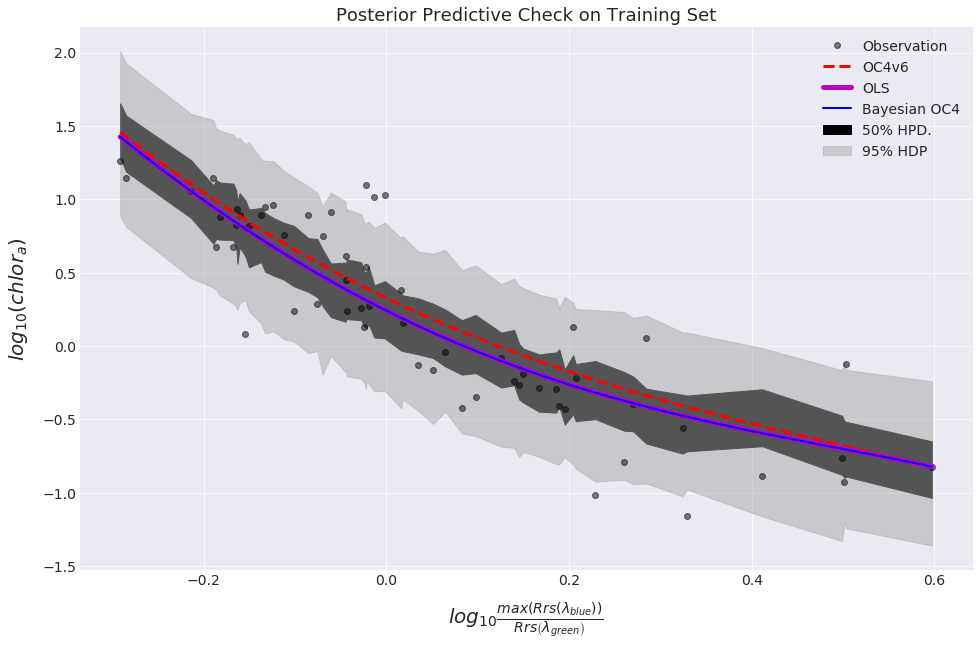

In [111]:
bayesCoeffs = [chainOCx_norm['a%d' %i].mean() for i in range(5)]
ax = PlotPPC(dfLogTest.seawifs_mxBl2Gr, dfLogTest.insitu_chlor_a,
             sig0, sig1, bayesCoeffs, oc4V6Coeffs=OC4v6_coeffs, myOLSCoeffs=genericOC4_Coefs)

In [112]:
chlMdlFreq = mdlFreq(dfLogTest.seawifs_mxBl2Gr) # evaluate polynomial with input data
chlMdlOc4v6 = mdlOC4v6(dfLogTest.seawifs_mxBl2Gr)
chlBayesReal=0
for i in range(5):
    chlBayesReal += traceOCx_norm['a%d' %i].mean()*dfLogTest.seawifs_mxBl2Gr**i
print("rmse, OLS: %.2f " % rmse(dfLogTest.insitu_chlor_a.values, chlMdlFreq))
print("rmse, OC4v6: %.2f " % rmse(dfLogTest.insitu_chlor_a.values, chlMdlOc4v6))
print("rmse, Bayes chl: %.2f" % rmse(dfLogTest.insitu_chlor_a.values, chlBayesReal))

rmse, OLS: 0.32 
rmse, OC4v6: 0.33 
rmse, Bayes chl: 0.32


In [117]:
with open('../pickleJar/basic_model.pkl', 'wb') as f:
    modelbox = {'model': model_OCx_norm,
               'trace': traceOCx_norm,
               'sharedVar': ocxRatioShrd}
    pickle.dump(modelbox, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
sb.distplot()

Again, frequentist diagnostics are equivalent for frequentist OLS and Bayesian regressions, with the usually observed higher performance observed for training data relative to the out-of-sample test data.

However, the point of the post was to demonstrate that the Bayesian approach can uncover a wealth of information about the components of the model and the model fit itself, not the least of which are naturally obtained model uncertainties. These, I have expressed as credibility intervals around the coefficients, and the fit.
That's it for this post. But that's not it for this dataset. The diagnostics displayed above have suggested that this model may be overly complex, and thereby prone to overfitting. In a subsequent post, I'll test a simpler model and use it as an excuse to explore the mysterious topic of model comparison.

Happy hacking, probabilistic or otherwise!